In [13]:

# 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
from pathlib import Path

ROOT = "/content/drive/MyDrive/INCS870/CICIoT2023"  # 你的根目录

# 关键字 → 规范化类别名（尽量覆盖常见命名）
def guess_label_from_path(p: str):
    s = p.lower()
    if "ddos" in s and "tcp" in s:  return "DDoS_TCP"
    if "ddos" in s and "udp" in s:  return "DDoS_UDP"
    if "benign" in s:               return "Benign"
    return None

# 递归搜集所有 csv，并用路径推断类别
file_list = []
for p in glob.glob(str(Path(ROOT) / "**/*.csv"), recursive=True):
    lab = guess_label_from_path(p)
    if lab is not None:
        file_list.append((p, lab))

print("发现到的 CSV：", len(file_list))
for p, lab in file_list[:6]:
    print("  ", lab, "->", os.path.relpath(p, ROOT))

# （可选）只保留三类
keep = {"Benign","DDoS_TCP","DDoS_UDP"}
file_list = [(p,l) for p,l in file_list if l in keep]
print("筛选后三类 CSV 数量：", len(file_list))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
发现到的 CSV： 4
   Benign -> Benign_final/BenignTraffic3.pcap.csv
   DDoS_TCP -> DDos_TCP/DDoS-TCP_Flood.pcap.csv
   DDoS_UDP -> DDos_UDP/DDoS-UDP_Flood1.pcap.csv
   DDoS_UDP -> DDos_UDP/DDoS-UDP_Flood20.pcap.csv
筛选后三类 CSV 数量： 4


In [14]:
import pandas as pd
import numpy as np

# 读入（可选：为了省内存，可设 max_rows_per_file & sample_per_class）
max_rows_per_file = None        # 比如 80000；None 表示全读
sample_per_class  = None        # 比如 每类采样 100000；None 表示不采样

dfs_by_class = {}
for path, lab in file_list:
    df_i = pd.read_csv(path, low_memory=False, nrows=max_rows_per_file)
    df_i["__label__"] = lab
    dfs_by_class.setdefault(lab, []).append(df_i)

# 合并每一类，并按需采样
frames = []
for lab, parts in dfs_by_class.items():
    big = pd.concat(parts, ignore_index=True)
    if sample_per_class is not None and len(big) > sample_per_class:
        big = big.sample(sample_per_class, random_state=42)
    frames.append(big)

df = pd.concat(frames, ignore_index=True)
print("raw shape:", df.shape, "| label counts:\n", df["__label__"].value_counts())

# 丢掉明显的标识/时间列（按需增减）
DROP_COLS = [c for c in ["id","ID","flow_id","Flow_ID","time","Time","timestamp","Timestamp"] if c in df.columns]
df = df.drop(columns=DROP_COLS)

# y：把标签转为 0..C-1
y, class_names = pd.factorize(df["__label__"], sort=True)
df = df.drop(columns=["__label__"])
print("classes:", list(class_names))

# X：one-hot + 缺失处理
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)

for c in df.columns:
    if df[c].dtype.kind in "biu":  # 整数/布尔
        df[c] = df[c].fillna(0)
    else:                          # 浮点
        df[c] = df[c].fillna(df[c].mean())

X = df.to_numpy()
X[np.isclose(X, 0.0, atol=1e-12)] = 0.0  # 压小噪声到 0，利于“非零重叠”判断
print("cleaned shape:", X.shape, "| n_classes:", np.unique(y).size)


raw shape: (741787, 40) | label counts:
 __label__
DDoS_UDP    346179
DDoS_TCP    265776
Benign      129832
Name: count, dtype: int64
classes: ['Benign', 'DDoS_TCP', 'DDoS_UDP']
cleaned shape: (741787, 39) | n_classes: 3


In [15]:
import numpy as np

def greedy_bundling_conflict(X, max_conflict=0, return_conflict=False):
    """
    Greedy Bundling (conflict-graph coloring):
    - 冲突定义：两列在同一行同时非零的次数。
    - 规则：遍历高冲突列，放入与现有成员 pairwise 冲突<=阈值的 bundle，否则新建 bundle。
    输入:
      X : (n,d) ndarray 或 DataFrame（稀疏请先 toarray）
      max_conflict : 允许的最大非零重叠（0=严格互斥）
    返回:
      bundles : List[List[int]]  每个子列表是一组被打包的原始列索引
      (可选) C : d×d 冲突矩阵（非零重叠计数）
    """
    if hasattr(X, "to_numpy"): X = X.to_numpy()
    if hasattr(X, "toarray"):  X = X.toarray()

    M = (X != 0).astype(np.uint8)  # 非零指示
    C = M.T @ M                    # 冲突矩阵=非零重叠次数
    np.fill_diagonal(C, 0)

    # 冲突度=与多少列的重叠>阈值；高冲突优先
    degree = (C > max_conflict).sum(axis=1)
    order  = np.argsort(-degree)

    bundles = []
    for f in order:
        placed = False
        for b in bundles:
            if (C[f, b] <= max_conflict).all():
                b.append(int(f)); placed = True; break
        if not placed:
            bundles.append([int(f)])
    return (bundles, C) if return_conflict else bundles


In [16]:
def efb_merge(X, bundles, method="sum"):
    """
    EFB 合并：把每个 bundle 合成一列。
    method="sum"    : 行求和（演示/one-hot常用）
    method="offsets": 为每列分配偏移槽，值域不重叠（可逆；适用于整数/非负）
    返回:
      Xb : (n, len(bundles)) 合并后的特征
      meta: 用于报告/还原的附加信息
    """
    if hasattr(X, "to_numpy"): X = X.to_numpy()
    if hasattr(X, "toarray"):  X = X.toarray()

    n = X.shape[0]
    Xb = np.zeros((n, len(bundles)), dtype=X.dtype)
    meta = {"method": method, "offsets": []}

    if method == "sum":
        for j, b in enumerate(bundles):
            Xb[:, j] = X[:, b].sum(axis=1)
        return Xb, meta

    elif method == "offsets":
        X_int = X.astype(np.int64, copy=False)
        for j, b in enumerate(bundles):
            base = 0; off = []
            for f in b:
                vmax = int(X_int[:, f].max()) if n else 0
                Xb[:, j] += X_int[:, f] + base
                off.append((int(f), base, vmax))
                base += vmax + 1
            meta["offsets"].append(off)
        return Xb, meta

    else:
        raise ValueError("method must be 'sum' or 'offsets'")


In [17]:
def multiclass_grad_at_uniform(y, num_class):
    """
    在均匀初始预测 p=1/C 处的多类交叉熵梯度幅值 ||P-Y||_2（演示用）。
    """
    n = len(y); C = num_class
    Y = np.zeros((n, C)); Y[np.arange(n), y] = 1.0
    P = np.full((n, C), 1.0/C)
    G = P - Y
    return np.linalg.norm(G, axis=1)

def goss_sample(g, top_rate=0.2, other_rate=0.2, random_state=42):
    """
    GOSS：保留大梯度top_rate；从小梯度中随机采样other_rate；
    小梯度样本在增益计算中乘 w_small = (1-top_rate)/other_rate。
    返回: big_idx, small_idx, w_small
    """
    rng = np.random.default_rng(random_state)
    n = len(g); k_top = max(1, int(np.ceil(top_rate*n)))
    order = np.argsort(-np.abs(g))
    big = order[:k_top]
    rest = order[k_top:]
    k_small = max(1, int(np.ceil(other_rate*n)))
    small = rng.choice(rest, size=min(k_small, len(rest)), replace=False)
    w_small = (1 - top_rate) / other_rate
    return np.sort(big), np.sort(small), float(w_small)


In [18]:
# === Greedy Bundling（不合并，先看分组）
bundles, C = greedy_bundling_conflict(X, max_conflict=0, return_conflict=True)
print(f"bundles={len(bundles)}  原始d={X.shape[1]}  压缩后B={len(bundles)}  压缩率={(1-len(bundles)/X.shape[1]):.2%}")
print("前3个bundle(索引):", bundles[:3])
# 展示被真正合并的bundle（size>1）及列名
multi = [b for b in bundles if len(b)>1][:5]
for b in multi:
    print("bundle:", b, "→", [df.columns[i] for i in b])

# === EFB Merge（把 bundle 合并成新特征）
Xb, meta = efb_merge(X, bundles, method="sum")  # 或 'offsets'
print("EFB 维度变化:", X.shape, "->", Xb.shape, "| method:", meta["method"])

# === GOSS（演示）
Cnum = int(np.max(y)) + 1
g = multiclass_grad_at_uniform(y, Cnum)
big, small, w = goss_sample(g, 0.2, 0.2)
print(f"GOSS: N={len(y)}  top={len(big)}  other={len(small)}  w_small={w:.1f}")


bundles=34  原始d=39  压缩后B=34  压缩率=12.82%
前3个bundle(索引): [[0], [1], [2]]
bundle: [12, 4] → ['syn_count', 'fin_flag_number']
bundle: [5, 13] → ['syn_flag_number', 'fin_count']
bundle: [21, 10, 27] → ['IRC', 'cwr_flag_number', 'IGMP']
bundle: [19, 9] → ['SMTP', 'ece_flag_number']
EFB 维度变化: (741787, 39) -> (741787, 34) | method: sum
GOSS: N=741787  top=148358  other=148358  w_small=4.0


Bundle size -> count
    1 -> 30
    2 -> 3
    3 -> 1


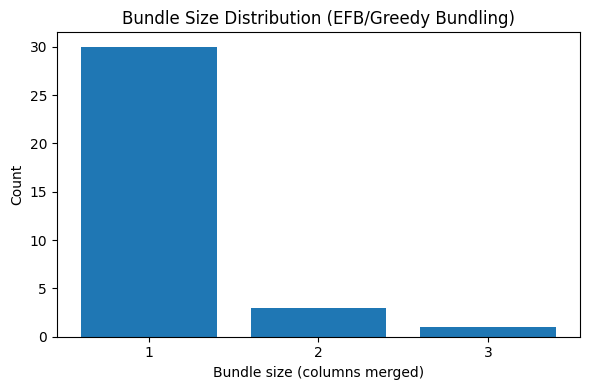

In [19]:
# 依赖：你已经有变量 `bundles`（来自前面的贪心打包）
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

assert 'bundles' in globals(), "未找到 bundles，请先运行贪心打包代码"

sizes = [len(b) for b in bundles]
cnt = Counter(sizes)

# 打印频次表
print("Bundle size -> count")
for k in sorted(cnt):
    print(f"{k:>5d} -> {cnt[k]}")

# 画柱状图
xs = np.array(sorted(cnt))
ys = np.array([cnt[k] for k in xs])

plt.figure(figsize=(6,4))
plt.bar(xs.astype(str), ys)   # 不指定颜色
plt.title("Bundle Size Distribution (EFB/Greedy Bundling)")
plt.xlabel("Bundle size (columns merged)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


N=741787 | top=148358 | sampled=148358 | dropped=445071


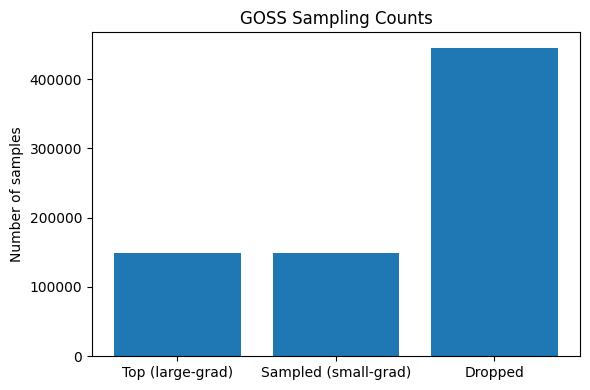

In [20]:
# 依赖：你已经有 y, g, big, small 变量（前面 GOSS 演示代码）
import numpy as np
import matplotlib.pyplot as plt

assert all(v in globals() for v in ['y','g','big','small']), "缺少 y/g/big/small，请先运行 GOSS 采样代码"

N = len(y)
n_top   = len(big)
n_other = len(small)
n_drop  = N - n_top - n_other

print(f"N={N} | top={n_top} | sampled={n_other} | dropped={n_drop}")

labels = ["Top (large-grad)", "Sampled (small-grad)", "Dropped"]
vals   = [n_top, n_other, n_drop]

plt.figure(figsize=(6,4))
plt.bar(labels, vals)   # 不指定颜色
plt.title("GOSS Sampling Counts")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()


mean|g|  top=0.816497 | sampled=0.816497 | rest(dropped)=0.816497


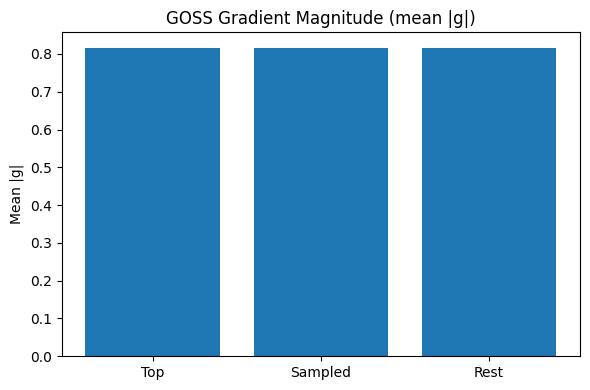

In [21]:
# 展示各组的 |g| 均值（能说明 top 组的梯度更大）
import numpy as np
import matplotlib.pyplot as plt

idx_all = np.arange(len(g))
mask_top   = np.zeros_like(idx_all, dtype=bool); mask_top[big] = True
mask_small = np.zeros_like(idx_all, dtype=bool); mask_small[small] = True
mask_rest  = ~(mask_top | mask_small)

mean_top   = float(np.mean(g[mask_top]))   if mask_top.any()   else 0.0
mean_small = float(np.mean(g[mask_small])) if mask_small.any() else 0.0
mean_rest  = float(np.mean(g[mask_rest]))  if mask_rest.any()  else 0.0

print(f"mean|g|  top={mean_top:.6f} | sampled={mean_small:.6f} | rest(dropped)={mean_rest:.6f}")

labels = ["Top", "Sampled", "Rest"]
vals   = [mean_top, mean_small, mean_rest]

plt.figure(figsize=(6,4))
plt.bar(labels, vals)   # 不指定颜色
plt.title("GOSS Gradient Magnitude (mean |g|)")
plt.ylabel("Mean |g|")
plt.tight_layout()
plt.show()
